Number of Brand Classes: 11
Number of Task Classes:  27

Training set shape:    (33, 9)
Validation set shape:  (11, 9)
Test set shape:        (11, 9)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                         

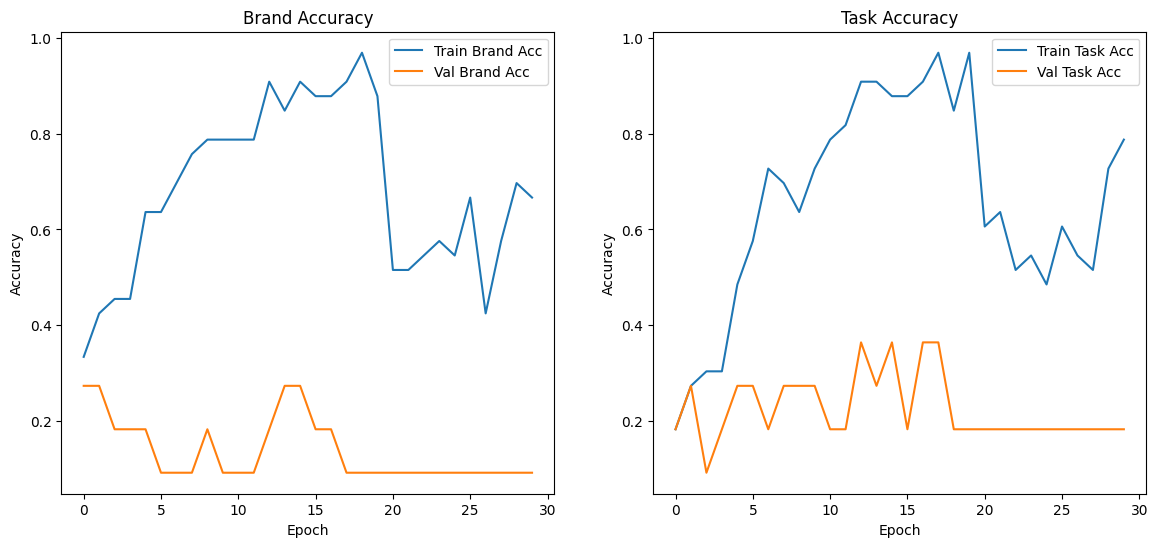

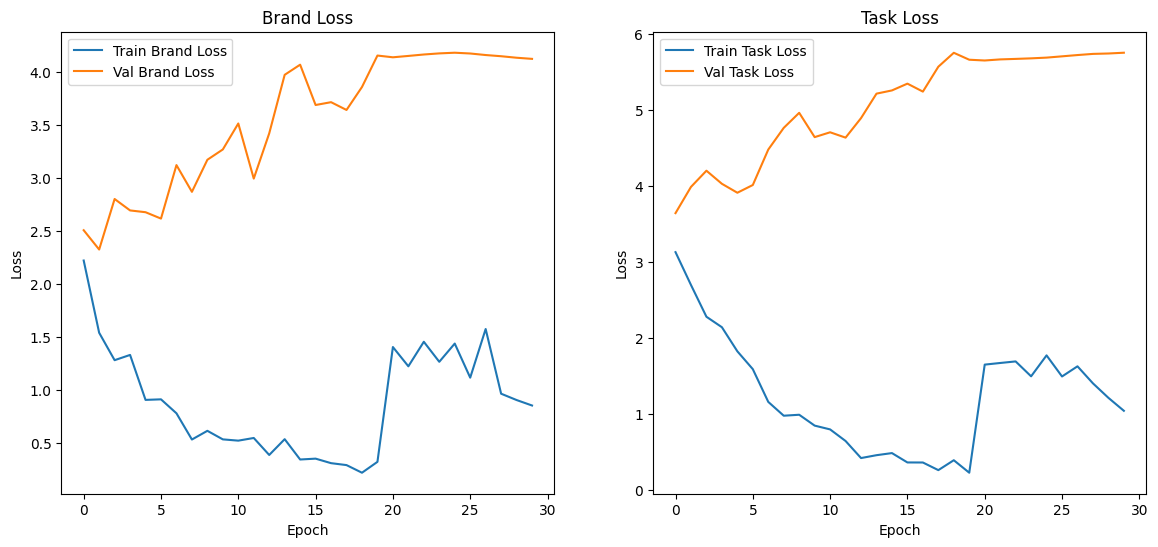

1/1 [==============================] - 0s 71ms/step


C:\Users\musab\AppData\Local\Temp\ipykernel_1820\1304885574.py:296: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
C:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


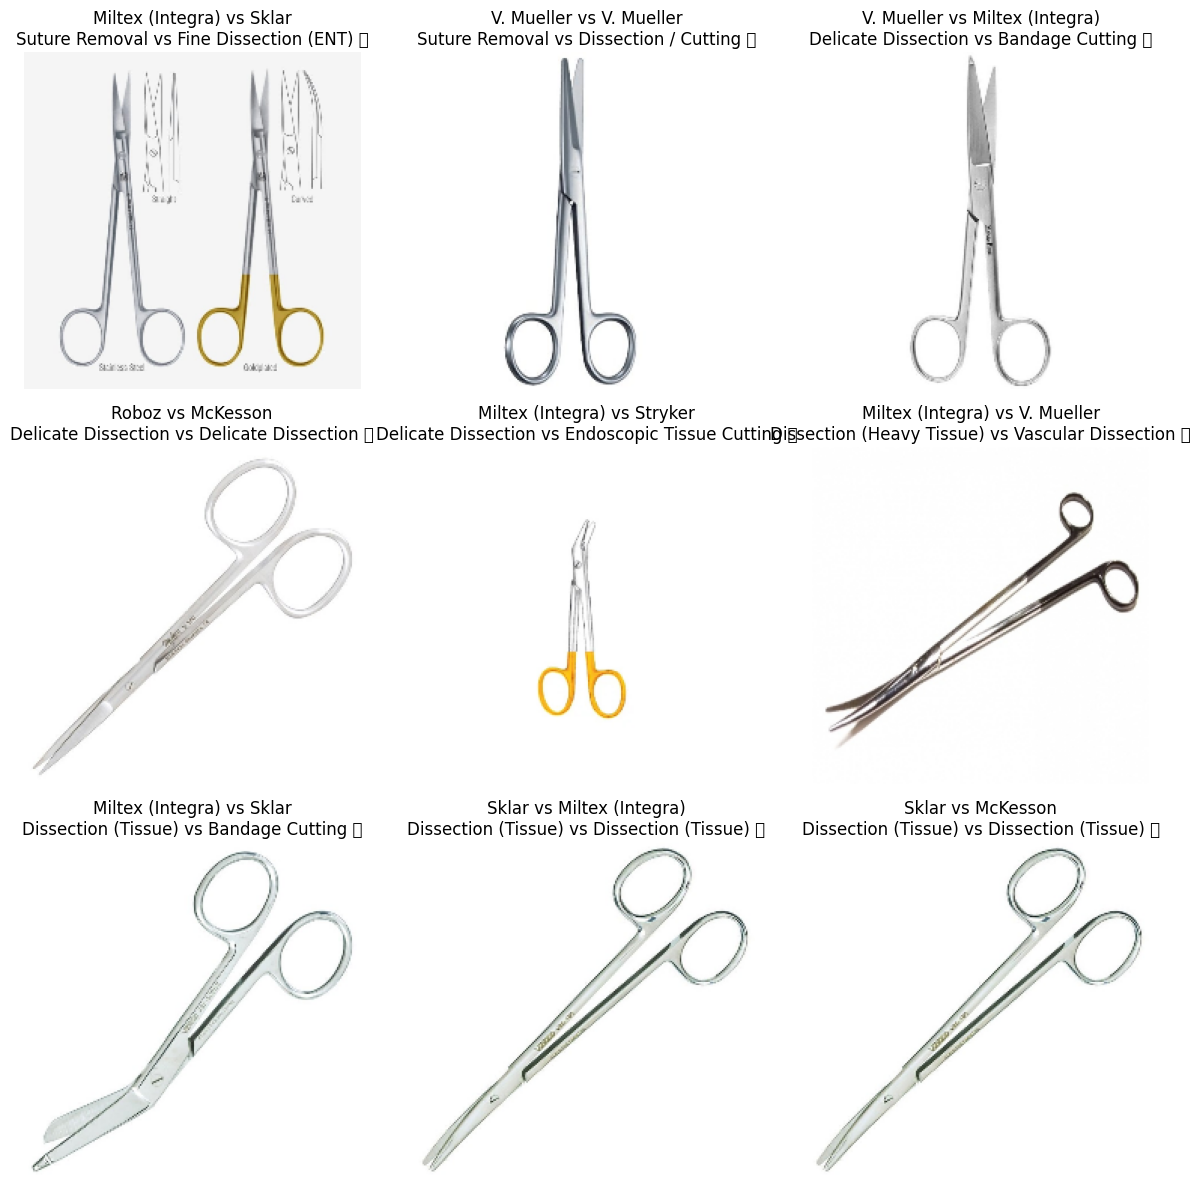

In [9]:
import logging, os
# before importing tensorflow:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
# ==========================
# 1. Import Libraries
# ==========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ==========================
# 2. Load and Preprocess CSV Data
# ==========================
csv_path = r"C:\Users\musab\DLScissor\data\dataset_updated.csv"
df = pd.read_csv(csv_path, encoding='latin-1')

# Encode the "Brand" and "Task Type" columns.
brand_le = LabelEncoder()
task_le  = LabelEncoder()
df['Brand_encoded'] = brand_le.fit_transform(df['Brand'])
df['Task_encoded']  = task_le.fit_transform(df['Task Type'])

num_brand_classes = len(brand_le.classes_)
num_task_classes  = len(task_le.classes_)
print("Number of Brand Classes:", num_brand_classes)
print("Number of Task Classes: ", num_task_classes)

# ==========================
# 3. Simple Train/Val/Test Split (60/20/20)
# ==========================
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42)

print("\nTraining set shape:   ", train_df.shape)
print("Validation set shape: ", val_df.shape)
print("Test set shape:       ", test_df.shape)

# ==========================
# 4. Build tf.data.Dataset Pipeline
# ==========================
IMG_SIZE   = (224, 224)
BATCH_SIZE = 8

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img

def create_dataset(df, batch_size=BATCH_SIZE, augment=False, shuffle=True):
    image_paths = df['Image Path'].values
    brand_labels = df['Brand_encoded'].values
    task_labels  = df['Task_encoded'].values
    
    ds = tf.data.Dataset.from_tensor_slices((image_paths, brand_labels, task_labels))
    
    def process_path(path, brand_label, task_label):
        img = load_and_preprocess_image(path)
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
        brand_onehot = tf.one_hot(brand_label, depth=num_brand_classes)
        task_onehot  = tf.one_hot(task_label,  depth=num_task_classes)
        return img, {'brand_output': brand_onehot, 'task_output': task_onehot}
    
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_df, augment=True,  shuffle=True)
val_ds   = create_dataset(val_df,   augment=False, shuffle=False)
test_ds  = create_dataset(test_df,  augment=False, shuffle=False)

# ==========================
# 5. Build the Multi‑Output Model
# ==========================
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # freeze feature extractor

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Brand branch
brand_branch = Dense(128, activation='relu')(x)
brand_output = Dense(num_brand_classes, activation='softmax', name='brand_output')(brand_branch)

# Task branch
task_branch = Dense(128, activation='relu')(x)
task_output = Dense(num_task_classes, activation='softmax', name='task_output')(task_branch)

model = Model(inputs=base_model.input, outputs=[brand_output, task_output])
model.summary()

# ==========================
# 6. Compile the Model
# ==========================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'brand_output': 'categorical_crossentropy',
          'task_output':  'categorical_crossentropy'},
    metrics={'brand_output': 'accuracy',
             'task_output':  'accuracy'}
)

# ==========================
# 7. Initial Training
# ==========================
initial_epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

# ==========================
# 8. Fine‑Tuning
# ==========================
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss={'brand_output': 'categorical_crossentropy',
          'task_output':  'categorical_crossentropy'},
    metrics={'brand_output': 'accuracy',
             'task_output':  'accuracy'}
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1
)

# ==========================
# 9. Evaluate on Test Set
# ==========================
y_true_brand = []
y_pred_brand = []
y_true_task  = []
y_pred_task  = []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true_brand.extend(np.argmax(labels['brand_output'], axis=1))
    y_true_task.extend( np.argmax(labels['task_output'],  axis=1))
    y_pred_brand.extend(np.argmax(preds[0], axis=1))
    y_pred_task.extend( np.argmax(preds[1], axis=1))

# Compute overall metrics
jaccard_brand = jaccard_score(y_true_brand, y_pred_brand, average='macro')
dice_brand    = f1_score(y_true_brand, y_pred_brand, average='macro')
jaccard_task  = jaccard_score(y_true_task,  y_pred_task,  average='macro')
dice_task     = f1_score(y_true_task,  y_pred_task,  average='macro')

print("\n--- Test Metrics ---")
print(f"Brand Classification  - Jaccard: {jaccard_brand:.4f}, Dice (F1): {dice_brand:.4f}")
print(f"Task Classification   - Jaccard: {jaccard_task:.4f}, Dice (F1): {dice_task:.4f}")

# Confusion matrices
print("\n--- Brand Confusion Matrix ---")
print(confusion_matrix(y_true_brand, y_pred_brand))
print("\n--- Task Confusion Matrix ---")
print(confusion_matrix(y_true_task, y_pred_task))

# Smart classification_report calls
unique_brands = sorted(set(y_true_brand) | set(y_pred_brand))
brand_names   = [brand_le.classes_[i] for i in unique_brands]

print("\n--- Brand Classification Report ---")
print(classification_report(
    y_true_brand,
    y_pred_brand,
    labels=unique_brands,
    target_names=brand_names,
    zero_division=0
))

unique_tasks = sorted(set(y_true_task) | set(y_pred_task))
task_names   = [task_le.classes_[i] for i in unique_tasks]

print("\n--- Task Classification Report ---")
print(classification_report(
    y_true_task,
    y_pred_task,
    labels=unique_tasks,
    target_names=task_names,
    zero_division=0
))

# ==========================
# 10. Visualize Training History
# ==========================
def combine_history(h1, h2, key):
    return h1.history[key] + h2.history[key]

epochs_range = range(total_epochs)

# Accuracy plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
train_b_acc = combine_history(history, history_finetune, 'brand_output_accuracy')
val_b_acc   = combine_history(history, history_finetune, 'val_brand_output_accuracy')
plt.plot(epochs_range, train_b_acc, label='Train Brand Acc')
plt.plot(epochs_range, val_b_acc,   label='Val Brand Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Brand Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
train_t_acc = combine_history(history, history_finetune, 'task_output_accuracy')
val_t_acc   = combine_history(history, history_finetune, 'val_task_output_accuracy')
plt.plot(epochs_range, train_t_acc, label='Train Task Acc')
plt.plot(epochs_range, val_t_acc,   label='Val Task Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Task Accuracy'); plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
train_b_loss = combine_history(history, history_finetune, 'brand_output_loss')
val_b_loss   = combine_history(history, history_finetune, 'val_brand_output_loss')
plt.plot(epochs_range, train_b_loss, label='Train Brand Loss')
plt.plot(epochs_range, val_b_loss,   label='Val Brand Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Brand Loss'); plt.legend()

plt.subplot(1, 2, 2)
train_t_loss = combine_history(history, history_finetune, 'task_output_loss')
val_t_loss   = combine_history(history, history_finetune, 'val_task_output_loss')
plt.plot(epochs_range, train_t_loss, label='Train Task Loss')
plt.plot(epochs_range, val_t_loss,   label='Val Task Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Task Loss'); plt.legend()
plt.show()

# ==========================
# 11. Sample Predictions
# ==========================
sample_df = test_df.sample(n=9, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 12))
for i, row in sample_df.iterrows():
    img = cv2.imread(row['Image Path'])
    img = cv2.resize(img, IMG_SIZE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    inp = preprocess_input(np.expand_dims(img.astype(np.float32), axis=0))
    p_brand, p_task = model.predict(inp)
    pb_idx = np.argmax(p_brand)
    pt_idx = np.argmax(p_task)

    pred_brand_label = brand_le.inverse_transform([pb_idx])[0]
    pred_task_label  = task_le.inverse_transform([pt_idx])[0]
    true_brand_label = row['Brand']
    true_task_label  = row['Task Type']

    mark = "✅" if (pred_brand_label == true_brand_label and pred_task_label == true_task_label) else "❌"

    plt.subplot(3, 3, i+1)
    plt.imshow(img_rgb)
    plt.title(f"{pred_brand_label} vs {true_brand_label}\n"
              f"{pred_task_label} vs {true_task_label} {mark}")
    plt.axis('off')

plt.tight_layout()
plt.show()
